This is the kaggle version of a Pierre Auger Observatory Open Data notebook. You can run it by clicking on "Copy and Edit" in the top right corner.

In [ ]:
![ -d /kaggle/input/release-2021-v1/augeropendata ] && [ ! -d augeropendata ] && ln -s /kaggle/input/release-2021-v1/augeropendata augeropendata  # kaggle specific linking dataset to augeropendata directory

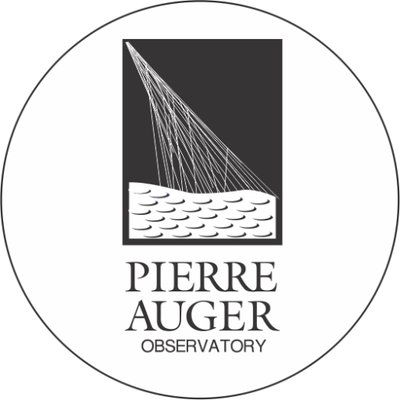

# Tutorial: how to read the summary files

<i>Notebook released together with the Pierre Auger Observatory Open Data release 2021 (<a href="https://doi.org/10.5281/zenodo.4487613">DOI 10.5281/zenodo.4487613</a>). More information at the <a href="https://www.auger.org/opendata/">Auger open data website</a>.</i>

The aim of this notebook is to give basic knowledges of data handling with python in a step-by-step way.

Import some standard python libraries that 
contain basic functions used along the notebook:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

import ipywidgets as widgets
from ipywidgets import  interactive

# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

In [ ]:
# Default values for plots
plt.rcParams["figure.figsize"] = [14, 9] # figure width and height
plt.rcParams["font.size"] = 20

In [ ]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerOpen(fdir, file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".", "..", "augeropendata", "data"]:
        fname = os.path.join(loc, fdir, file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc, fdir + ".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir, file))
    raise FileNotFoundError(os.path.join(fdir, file))

Upload the summary file as a pandas dataframe:

In [ ]:
df = pd.read_csv(AugerOpen("summary", "dataSummary.csv"))

List the fields (columns) of the dataframe:

In [ ]:
df.columns

A row in the dataframe collects the reconstruction values of an event. 
If an event is a _multi-eye Hybrid_, its row (with the same id) is duplicated and each one contains the reconstruction values of one _eye_, with the values for the SD repeated.
In *golden-hybrid* events, all fields are filled. In _SD only_ or _brass-hybrid_ events some fields are empty (NaN).

A preview of the dataframe content:

In [ ]:
df.head(10)

Get multi-eye events:

In [ ]:
df[df['multiEye'] == 1].head(10)

Get unique event (for SD analysis):

In [ ]:
df_unique = df.drop_duplicates('id')
df_unique.head(10)

Let's look at the number of unique and of duplicate event `id`s. A duplicate event `id` indicates a multi-eye event:

In [ ]:
n_events = len(df)
n_columns = len(df.columns)
n_unique = len(df_unique)
n_duplicates = n_events - n_unique
Latex(f'''The dataframe contains {n_events} rows and {n_columns} columns.
    There are {n_unique} different events, of which {n_duplicates} are multi-eye events.''')

## Extract date-time information from the event

### Date from the event `id`

The event identification number is a 12-digit number:

YYDDDSSSSSXX

- YY : last 2 digits of year
- DDD : day number between 1 and 366
- SSSSS: Second of the current DAY between 0 and 86399
- XX : order of the event at the current second


In this example the variable `event_id` is initialized with the content of the field `id` in the dataframe, then it is converted in a `datetime` variable (UTC) and added to the dataframe as a new column called `date`.

In [ ]:
event_id = df.id

# extract date and time from id using integer division // and modulus
year_factor = 10**10
day_factor =  10**7
day_modulus = 10**3
second_factor = 100
second_modulus = 10**5

years = event_id // year_factor
days = event_id // day_factor % day_modulus
seconds = event_id // second_factor % second_modulus
years = years + 2000

# generate a 'datetime' variable
# NB: the Auger day starts at noon UTC
date = [datetime.datetime(year, 1, 1, 12, tzinfo=datetime.timezone.utc) + datetime.timedelta(days=day - 1, seconds=second - 1) 
        for year, day, second in zip(years, days, seconds)]
# add the column 'date' to the dataframe
df['date']=date

Print the 'id' list and the corresponding date:

In [ ]:
df[['id', 'date']] 

### GPS time conversion

Compare the gps seconds in an event to the time difference between the event timestamp built from the event `id` and the beginning of the GPS time. We notice a small difference, since the system time does not take leap seconds into account, which occurred between the beginning of the GPS counting on January 6, 1980 at 0:00 UTC, and the date under consideration. The number difference in 2020 is 18 seconds. In 2004, the difference was 13 seconds. 

In [ ]:
gps0 = datetime.datetime(1980, 1, 6, tzinfo=datetime.timezone.utc) # The start of the gps counting of seconds

In [ ]:
date_gps = gps0 + datetime.timedelta(seconds=int(df.gpstime.iloc[0]))
leapseconds = (date_gps - df.iloc[0]['date']).total_seconds() # the difference is the number of leap seconds 

display(Latex(f'gpstime:  {int(df.gpstime.iloc[0])}'))
display(Latex(f'date-time from gps: {date_gps}'))
display(Latex(f'date-time from id: {df.date.iloc[0]}'))
display(Latex(f'Difference (leapseconds):  {int(leapseconds)}'))


## Select SD and hybrid subsets

The field `sd_energy` represents the SD reconstructed energy. Then we can use the condition "`sd_energy` is not NaN" to select reconstructed SD events.
To select only events where the efficiency of the SD is close to 100%, we have to require that the event energy is greater than 2.5 EeV.

The field `fd_totalEnergy` represents the total energy reconstructed in hybrid events.
We can use the condition "`fd_totalEnergy` is not NaN" to select reconstructed hybrid events.

In [ ]:
#extract sd and hybrid subsets - test for NaN to see if field is present

df_unique = df.drop_duplicates('id') # re-calculate, since we added the date field

df_sd = df_unique[df_unique.sd_energy.notna()]
#df_sd = df_unique[df_unique.sd_energy>2.5]  #this statement excludes events below full efficiency of the SD

df_fd = df[df.fd_totalEnergy.notna()]


display(Latex(f'Number of SD events:  {len(df_sd)}'))
display(Latex(f'Number of hybrid events:  {len(df_fd.groupby("id"))}'))

## Plot a variable distribution

To plot an histogram use the method 'hist' from the library 'matplotlib.pyplot'.
In the following example, you can plot the distribution of the energy obtained from the SD reconstruction.

In [ ]:
plt.hist(df_sd.sd_energy, bins=100)
plt.yscale('log')
plt.xlabel('$E_{SD}$ [EeV]')
plt.ylabel('entries')
plt.show()

If you want to plot two histograms in the same figure, you can use the method 'subplots'.
In the following example, you can find the distributions of zenith and azimuth angles for SD-reconstructed events.

In [ ]:
plt.figure(figsize=(15, 5)) 
plt.subplot(121)
plt.hist(df_sd.sd_theta, bins=60)
plt.yscale('log')
plt.ylabel('entries')
plt.xlabel(r'$\theta$ [deg]')

plt.subplot(122)
plt.hist(df_sd.sd_phi,bins=360)
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel('entries')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

## Temporal trend of an observable

In the following example you can calculate the mean value of an observable, in this case the zenith angle, in a time period (year) and plot its trend.

In [ ]:
#calculate mean values of the variable sd_theta, its standard error and the number of events per year   
theta_mean   = df_sd.groupby([(df_sd.date.dt.year)])['sd_theta'].mean()
theta_counts = df_sd.groupby([(df_sd.date.dt.year)])['sd_theta'].count()
theta_std    = df_sd.groupby([(df_sd.date.dt.year)])['sd_theta'].std()
theta_err    = theta_std/np.sqrt(theta_counts)

#calculate the mean value of the variable sd_theta for all events to plot the corresponding line
line_x = [2004, 2018] 
line_y = [df_sd.sd_theta.mean(), df_sd.sd_theta.mean()] 

plt.errorbar(theta_mean.index, theta_mean.values, yerr=theta_err, linestyle='None', marker='o')
plt.xlabel('year') 
plt.ylabel(r'$\langle\Theta\rangle$ [deg]') 
plt.plot(line_x,line_y, c='red', label='mean value', linestyle='dotted') 
plt.ylim(34, 40)    
plt.legend() 

plt.grid()
plt.show()

In the following example you can compare the daily number of SD reconstructed events to the monthly-averaged and yearly-averaged rate.

In [ ]:
#first count how many days are in each month and year
dict_date = {'year': df_sd.date.dt.year, 'month': df_sd.date.dt.month, 'day': df_sd.date.dt.day}
df_date = pd.DataFrame(dict_date)
df_date = df_date.drop_duplicates()
counts_month_days = df_date.groupby([(df_date.year), (df_date.month)])['day'].count() #count days in each month
counts_year_days = df_date.groupby([(df_date.year)])['day'].count() #count days in each year

#count the number of events per day, month, and year (you can the same calculation  using anyother variable)
counts_day = df_sd.groupby([(df_sd.date.dt.year), (df_sd.date.dt.month), (df_sd.date.dt.day)])['sd_energy'].count()
counts_month = df_sd.groupby([(df_sd.date.dt.year), (df_sd.date.dt.month)])['sd_energy'].count()
counts_year = df_sd.groupby([(df_sd.date.dt.year)])['sd_energy'].count()

#the following instructons are useful to uniformize the x axis of the plots
x_day = [datetime.datetime(year, month, day) for year, month, day in zip([item[0] for item in counts_day.index.values], 
                                                                         [item[1] for item in counts_day.index.values],
                                                                         [item[2] for item in counts_day.index.values])]
x_month = [datetime.datetime(year, month, 1) for year, month  in zip([item[0] for item in counts_month.index.values],
                                                                     [item[1] for item in counts_month.index.values])]
x_year = [datetime.datetime(year, 1, 1) for year in counts_year.index.values]


#plot the day-normalized trends
plt.plot(x_day, counts_day.values, linestyle='None', marker='.', markersize=1, label='daily')
plt.plot(x_month, counts_month.values/counts_month_days, label='monthly averaged')
plt.plot(x_year, counts_year.values/counts_year_days, label='yearly averaged')
plt.legend()
plt.title('Events per day')
plt.xlabel('year')
plt.ylabel('counts')
plt.show()

In the following example you can calculate the mean Xmax value per year. In this example we use the variable fd_gpstime as temporal reference.

In [ ]:
gps_to_unix0 = 315964782 # the difference between unix timestamps and GPS seconds at the beginning of the GPS epoch

gps    = df_fd.gpstime
xmax   = df_fd.fd_xmax

date_gps=[datetime.datetime.utcfromtimestamp(i + gps_to_unix0) for i in gps]
frame = { 'date': date_gps, 'xmax': xmax} 
dataframe=pd.DataFrame(frame)
dataframe['year'] = pd.DatetimeIndex(dataframe['date']).year
dataframe['month'] = pd.DatetimeIndex(dataframe['date']).month

mean_xmax=dataframe.groupby([(dataframe.year)])['xmax'].mean()
sigma_xmax=dataframe.groupby([(dataframe.year)])['xmax'].std()
counts_xmax=dataframe.groupby([(dataframe.year)])['xmax'].count()

mean_xmax.plot(ylabel=r'$\langle X_{max} \rangle$ [g/cm${}^2$]', marker='o', ylim=[670, 800], 
               linestyle='none', yerr=sigma_xmax/np.sqrt(counts_xmax))
plt.grid()
plt.show()

## Maps

Plot the map of the array using the UTM coordinates of the stations: using the interactive slider you can see the station-deployment process:

In [ ]:
sdmap = pd.read_csv(AugerOpen("auxiliary", "sdMap.csv"))

def augerArray(t):
    timeMap = sdmap.loc[(sdmap['start']<t) & ((sdmap['stop']>t) | (sdmap['stop']==1))]
    
    display(Latex(f'Number of stations: {len(timeMap)} '))
    display(Latex(f'Date: {datetime.datetime.utcfromtimestamp(t + gps_to_unix0).date()} '))

    plt.figure(figsize=(12, 12))
    plt.scatter(timeMap.easting, timeMap.northing, s=20)
    plt.xlim(439000, 510000)
    plt.ylim(6065000, 6140000)
    plt.xlabel('UTM Easting [m]')
    plt.ylabel('UTM Northing [m]')
    
    plt.show()
interactive(augerArray, t=widgets.IntSlider(description='gpstime ',value=1241890123, max=1241890123, min=735350400, step=1))

Plot the map of the array using the core position at the ground of SD events in site coordinate system:

In [ ]:
plt.scatter(df["sd_x"], df["sd_y"], c=df["sd_z"], linestyle="None", marker='.', cmap='brg')
plt.axis('off')
clb = plt.colorbar()
clb.ax.set_title('Altitude [m]')
plt.show()

Plot the map of the array using stations position (grey dots) and the core position at the ground of hybrid  events (blue dots) in UTM coordinate system.

In [ ]:
#define the UTM coordinate of FD sites
LL= [6071871.5, 459208.3, 1416.2] # Norhing  Easting Altitude
LM= [6094570.2, 498903.7, 1416.4]
LA= [6134058.4, 480743.1, 1476.7]
CO= [6114140.0, 445343.8, 1712.3]


plt.figure(figsize=(10, 10))

plt.scatter(LL[1], LL[0], marker='^', s=500, label='LL')
plt.scatter(LM[1], LM[0], marker='^', s=500, label='LM')
plt.scatter(LA[1], LA[0], marker='^', s=500, label='LA')
plt.scatter(CO[1], CO[0], marker='^', s=500, label='CO')
plt.annotate('Los Leones', xy=(LL[1]-4000, LL[0]-4000))
plt.annotate('Los Morados', xy=(LM[1]-4000, LM[0]-5000))
plt.annotate('Loma Amarilla', xy=(LA[1]-4000, LA[0]+4000))
plt.annotate('Coihueco', xy=(CO[1]-8500, CO[0]+4000))

plt.scatter(sdmap["easting"], sdmap["northing"], c='grey', alpha=0.5)
plt.scatter(df["fd_easting"], df["fd_northing"], marker='.', c='blue')
plt.axis('off')
plt.show()

Plot the map of the arrival direction of SD events in the Galactic coordinate system (Galactic longitude and latitude). 
This example is meant to illustrate how to build a sky-map in Galactic coordinates and does not represent an analysis of the arrival direction of the SD events. Such analysis is available in the notebook "The UHECR sky"

In [ ]:
log_en = np.log10(df_sd.sd_energy*1e18)

def update(emin, emax, angle, alpha):    

    lat = df_sd.sd_b[log_en.between(emin, emax)].values
    longit = df_sd.sd_l[log_en.between(emin, emax)].values
   
    en = log_en[log_en.between(emin, emax)]
 
    display(Latex(f'{emin} < Energy [Log(E/eV)] <  {emax}'))
    display(Latex(f'Angular resolution = {angle}°'))
    display(Latex(f'Numbers of events = {len(en)}'))

    lat_rad = np.radians(lat)
    longit_tmp = []
    for lon in longit:
        if(lon < 180):
            longit_tmp.append(lon)
        else:
            longit_tmp.append(lon - 360)
    longit_rad =  np.asarray(np.radians(longit_tmp))

    delta_longit = 360/angle
    delta_lat = 180/angle
    bins = [int(delta_longit), int(delta_lat)]

    hh, locx, locy = np.histogram2d(longit_rad, lat_rad, bins=bins)
    z = np.array([hh[np.argmax(a<=locx[1:]), np.argmax(b<=locy[1:])] for a, b in zip(longit_rad, lat_rad)])
    idx = z.argsort() 
    x2, y2, z2 = longit_rad[idx], lat_rad[idx], z[idx] 
    fig = plt.figure(figsize=(14, 14)) 
    ax = fig.add_subplot(111, projection="aitoff")
    ax = plt.scatter(x2, y2, c=z2,  s=8, alpha=alpha) 

    plt.grid(True)
    plt.show()
    
w = interactive(update, emin=widgets.FloatSlider(description='En. min. ',value=18.4, max=21, min=18.4, step=0.1), 
                emax=widgets.FloatSlider(description='En. max. ', value=19.5, max=21, min=18.4, step=0.1),
                angle=widgets.IntSlider(description='Ang. Res. ', value=10, max=45, min=5, step=1),
                alpha=widgets.FloatSlider(description='Opacity', value=0.3, max=1., min=0.1, step=0.1))
display(w)

## Correlation plots

In the following examples the correlation between some observables from the hybrid dataset is shown.

Correlation between the FD reconstructed energy and the maximum energy deposit.


In [ ]:
plt.scatter(df_fd.fd_totalEnergy, df_fd.fd_dEdXmax)
plt.xlabel('FD Energy [EeV]')
plt.ylabel('dEdXmax [$PeV(g/cm^2)$]')
plt.grid()

## Energy trend

Hybrid events contain some flags that indicate the analyses they are used for: 'fd_hdXmaxEye' , 'fd_hdSpectrumEye', 'fd_hdCalibEye'.


The following example shows the Xmax as a function of energy for the different dataset

In [ ]:
#Select a subset of events for each analysis:

df_xmax = df_fd[df_fd.fd_hdXmaxEye==1]
df_spectrum = df_fd[df_fd.fd_hdSpectrumEye==1]
df_calib = df_fd[df_fd.fd_hdCalibEye==1]

In [ ]:
#Plot the value of Xmax as a function of the energy for the different sub-samples.
plt.plot(np.log10(df_xmax.fd_totalEnergy)+18, df_xmax.fd_xmax, markersize=4, c='r', marker='o' ,linestyle='None', label='hdXmax') 
plt.plot(np.log10(df_spectrum.fd_totalEnergy)+18, df_spectrum.fd_xmax, markersize=3, c='b', marker='o' ,linestyle='None', label='hdSpectrum') 
plt.plot(np.log10(df_calib.fd_totalEnergy)+18, df_calib.fd_xmax, markersize=2, c='k', marker='o' ,linestyle='None', label='hdCalib') 
plt.ylabel('Xmax $[g/cm^2]$')
plt.xlabel('$Log_{10}$(E/eV)')
plt.legend()
plt.grid()
plt.show()

As you can see, the energy-threshold is different for the different  analyses.

## How to read auxiliary files 

### sdMap.csv

This file contains the position in UTC coordinate system of all stations of the surface detector and time period of activity:

    id: identification number of the station
    northing,easting,altitude: UTC coordinates
    start: GPS time of the first event detected by the station
    stop: GPS time of the last event detected by the station. The value is 1 if the station is still in operation

In [ ]:
sdmap = pd.read_csv(AugerOpen("auxiliary", "sdMap.csv"))

display(sdmap.head(10))

### fdPixelMap.csv

This file contains information about the position of a pixel in the FD telescopes and its pointing direction:

    pixel:  identification number of the pixel[0-2639]
    eye: identification number of the FD site [1-4]
    pixelTel: identification number of the pixel in an FD telescope[1-440] 
    tel: identification number of the telescope [1-6]
    elevation,azimuth: pointing direction of the pixel [deg]
    col,row: number of column [1-20] and row [1-22] of the pixel in the telescope


In [ ]:
pixelmap = pd.read_csv(AugerOpen("auxiliary", "fdPixelMap.csv"))

display(pixelmap.head(10))

### sdExposure.csv

This file contains the value of the integrated exposure of the surface detector at the time
of each SD reconstructed event with energy > 2.5 EeV

    gpstime: GPS 
    sd_exposure:  value of the exposure at the corresponding GPS normalized to 10%
    sd_exposure_all:  value of the exposure at the corresponding GPS

In [ ]:
exposure = pd.read_csv(AugerOpen("auxiliary", "sdExposure.csv"))

display(exposure.head(10))

### fdXmaxAcceptance.csv

The FD-related "fdXmaxAcceptance.csv" file is a CSV version of the 
Table II in Appendix B of [Phys. Rev. D 90, 122005 (2014)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.90.122005), ([arXiv](https://arxiv.org/pdf/1409.4809.pdf)), and contains the energy-dependent properties of the acceptance of FD-reconstructed Xmax.

    energyBin: index of energy bin
    lgMinEnergy: start of energy bin [log10(E/eV]
    lgMaxEnergy: end of energy bin [log10(E/eV]
    Xacc1: the Xmax value below which acceptance effects become relevant [g/cm2]
    Xacc1err: statistical error of former [g/cm2]
    Xacc2: the Xmax value above which acceptance effects become relevant [g/cm2]
    Xacc2err:  statistical error of former [g/cm2]
    lambda1: exponential slope of acceptance for Xmax<Xacc1 [g/cm2]
    lambda1err:  statistical error of former [g/cm2]
    lambda2: exponential slope of acceptance for Xmax>Xacc2 [g/cm2]
    lambda2err: statistical error of former [g/cm2]

In [ ]:
acceptance = pd.read_csv(AugerOpen("auxiliary", "fdXmaxAcceptance.csv"))

display(acceptance.head(10))

### fdXmaxResolution.csv

The FD-related  "fdXmaxResolution.csv" file is a CSV version of the 
Table III in Appendix B of [Phys. Rev. D 90, 122005 (2014)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.90.122005), ([arXiv](https://arxiv.org/pdf/1409.4809.pdf)), and contains the energy-dependent properties of the resolution of FD-reconstructed Xmax.

    energyBin: index of energy bin
    lgMinEnergy: start of energy bin [log10(E/eV)]
    lgMaxEnergy: end of energy bin [log10(E/eV)]
    sigma1: width of first Gaussian [g/cm^2]
    sigma1Err: statistical error of former [g/cm^2]
    sigma2: width of second Gaussian [g/cm^2]
    sigma2Err: statistical error of former [g/cm^2]
    f: relative weight between two Gaussians [1]

In [ ]:
resolution = pd.read_csv(AugerOpen("auxiliary", "fdXmaxResolution.csv"))

display(resolution.head(10))